In [1]:
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import corner
import emcee
import scipy.optimize as op
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"


band1 = 'r'
band2 = 'w2'

R, Input, T = getBand('ESN_HI_catal.csv', band1=band1 , band2=band2)
r_w1    = Input[1]
pc0     = Input[2]
inc     = Input[3]
table = T[5]
Er_w1 = table['Er_w1']
Epc0  = table['Epc0']
Einc  = table['inc_e']


a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
q2 = 10**(-1.*theta)

A = r_w1-(alpha*pc0+beta)
EA = np.sqrt(Er_w1**2+(alpha*Epc0)**2)

_pc, _inc = np.linspace(-4,4,30), np.linspace(45,90,30)
_pc, _inc = np.meshgrid(_pc, _inc)
_A = log_a_b(_inc, q2)*(a*_pc**3+b*_pc**2+c*_pc+d)

# indx = np.where(_A<0)
# _A[indx]=0


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(_pc, _inc, _A.reshape(_inc.shape), cmap=cm.seismic, linewidth=0, alpha=0.2, antialiased=False)
#ax.plot_wireframe(_pc, _inc, _A.reshape(_inc.shape), alpha=0.2)


ax.scatter(pc0[0:300],inc[0:300],A[0:300], c=A[0:300], cmap=cm.seismic, alpha=1.0, marker='.')



pc__ = _pc
inc__ = _inc
A__ = _A

redTools.py:55: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)


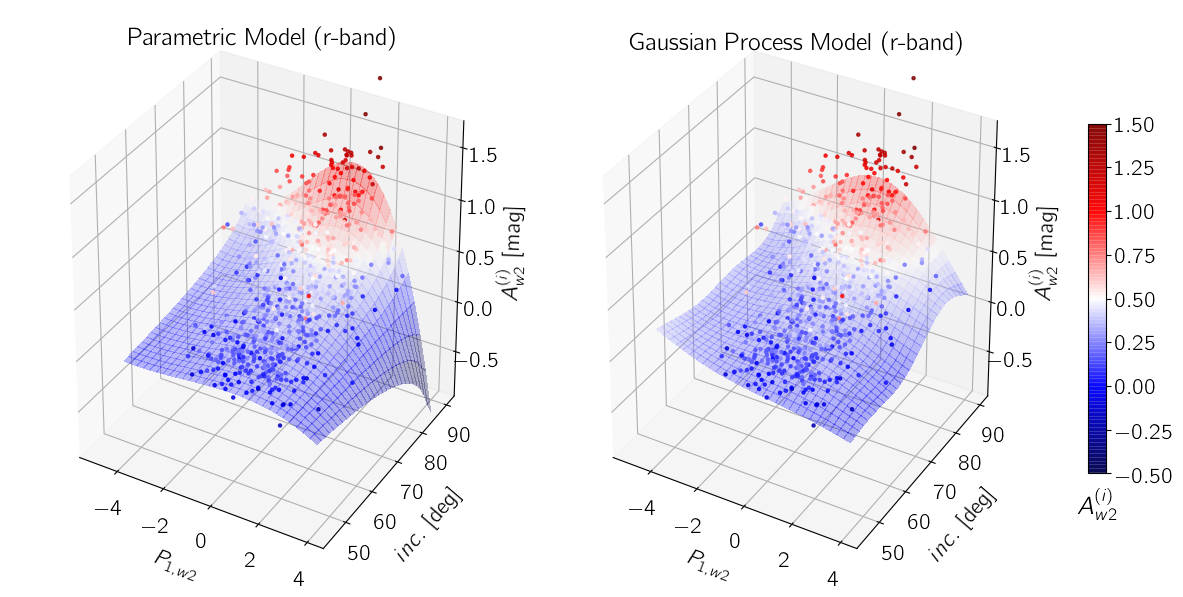

In [2]:
import george
from george import kernels

_, Input, T = getBand('ESN_HI_catal.csv', band1=band1 , band2=band2)
r_w1    = Input[1]
pc0     = Input[2]
inc     = Input[3]

a,b,c,d, alpha, beta, gamma, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
R = r_w1-(alpha*pc0+beta)
A = R
y = R

N = len(pc0)
dR2 = Er_w1**2+(alpha*Epc0)**2+(Ealpha*pc0)**2
noise2 = dR2*np.eye(N)

X = np.ones(shape = (2,N))
X[0] = pc0
X[1] = inc
X = X.T

theta = george_params(band1='r')
    
l1 = np.exp(theta[0])
l2 = np.exp(theta[1])
sigma = np.exp(theta[2])
yerr = np.diagonal(np.sqrt(noise2))+theta[3]
###########kernel = sigma * kernels.Matern52Kernel([l1,l2], ndim=2, axes=[0, 1]
kernel = sigma * kernels.ExpSquaredKernel([l1,l2], ndim=2, axes=[0, 1])

gp = george.GP(kernel)
gp.compute(X, yerr)


_pc, _inc = np.linspace(-4,4,30), np.linspace(45,90,30)
_pc, _inc = np.meshgrid(_pc, _inc)
X_ = np.c_[_pc.ravel(), _inc.ravel()]

_A, var_A = gp.predict(A, X_, return_var=True)

fig = py.figure(figsize=(12, 6), dpi=100) 
fig.subplots_adjust(wspace=0.1, top=0.97, bottom=0.02, left=0.01, right=0.92)
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,0.05])

colormap = cm.seismic #or any other colormap
normalize = colors.Normalize(vmin=-0.5, vmax=1.5)

# ax = fig.add_subplot(1, 2, 1, projection='3d')
ax = plt.subplot(gs[0], projection='3d')
ax.plot_surface(pc__, inc__, A__, norm=normalize, cmap=colormap, linewidth=0, alpha=0.3, antialiased=False)
p = ax.scatter(pc0[0:700],inc[0:700],A[0:700], c=A[0:700], norm=normalize, cmap=colormap, alpha=0.8, marker='.')

ax.set_title('Gaussian noise with vertical colorbar')
for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
for tick in ax.zaxis.get_major_ticks():
            tick.label.set_fontsize(16)  
ax.set_zlim(-0.9,1.7)
ax.set_title('Parametric Model ('+band1+'-band)', fontsize=18, pad=40)
ax.set_xlabel(r'$P_{1,w2}$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$inc.$'+' [deg]', fontsize=16, labelpad=10)
ax.set_zlabel(r'$A^{(i)}_{w2}$'+' [mag]', fontsize=16, labelpad=10)

################################################################################

# ax = fig.add_subplot(1, 2, 1, projection='3d')
ax = plt.subplot(gs[1], projection='3d')
ax.plot_surface(_pc, _inc, _A.reshape(_pc.shape), norm=normalize, cmap=colormap, linewidth=0, alpha=0.3, antialiased=False)
p = ax.scatter(pc0[0:700],inc[0:700],A[0:700], c=A[0:700], norm=normalize, cmap=colormap, alpha=0.8, marker='.')

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
for tick in ax.zaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
ax.set_zlim(-0.9,1.7)
ax.set_title('Gaussian Process Model ('+band1+'-band)', fontsize=18)  
ax.set_xlabel(r'$P_{1,w2}$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$inc.$'+' [deg]', fontsize=16, labelpad=10)
ax.set_zlabel(r'$A^{(i)}_{w2}$'+' [mag]', fontsize=16, labelpad=10)

# ax = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = plt.subplot(gs[2])
ax2.set_axis_off()  
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
cbar = fig.colorbar(p, fraction=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xlabel(r'$A^{(i)}_{w2}$', fontsize=18, labelpad=15)


################################################################################

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression

# regr = RandomForestRegressor(max_depth=2000, n_estimators=2000, max_features=2, \
#                              min_samples_leaf=10, bootstrap=True)
# regr.fit(X, y)

# _pc, _inc = np.linspace(-4,4,30), np.linspace(45,90,30)
# _pc, _inc = np.meshgrid(_pc, _inc)
# X_ = np.c_[_pc.ravel(), _inc.ravel()]

# A_  = regr.predict(X_)

# ax = plt.subplot(gs[3], projection='3d')
# ax.plot_surface(_pc, _inc,A_.reshape(_pc.shape), norm=normalize, cmap=colormap, linewidth=0, alpha=0.3, antialiased=False)
# ax.scatter(pc0[0:700],inc[0:700],R[0:700], c=R[0:700], norm=normalize, cmap=colormap, alpha=0.8, marker='.')
# for tick in ax.xaxis.get_major_ticks():
#             tick.label.set_fontsize(16) 
# for tick in ax.yaxis.get_major_ticks():
#             tick.label.set_fontsize(16) 
# for tick in ax.zaxis.get_major_ticks():
#             tick.label.set_fontsize(16) 
# ax.set_zlim(-0.9,1.7)
# ax.set_title('Random Forest Model ('+band1+'-band)', fontsize=18)  
# ax.set_xlabel(r'$P_{1,w2}$', fontsize=16, labelpad=10)
# ax.set_ylabel(r'$inc.$'+' [deg]', fontsize=16, labelpad=10)
# ax.set_zlabel(r'$A^{(i)}_{w2}$'+' [mag]', fontsize=16, labelpad=10)

################################################################################


fig.savefig("Param_GP_"+band1+"w2.png")
# fig.savefig("Param_GP_RFـ"+band1+"w2.eps")